# EWMA and PEWMA examples

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tsanomaly as ad
import tsanomaly.expsmooth as exp

In [2]:
CHART_HEIGHT = 3

In [3]:
df = pd.read_csv("./data/DailyDelhiClimateTrain.csv").set_index("date")
df.index = pd.to_datetime(df.index)
df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


## 1 EWMA

The exponentially weighted moving average $M_t$ at time $t$ is given by

$$ M_t = \alpha x_t + (1 - \alpha) M_{t-1} $$

where $\alpha \in [0, 1]$ is a weight applied to the current time series value $x_t$. $M$ is an estimate of the series mean.

We can see the exponential drop off when we expand some $M_t$ terms. Here's an example:

\begin{align}
M_t &= \alpha x_t + (1 - \alpha) M_{t-1} \\
    &= \alpha x_t + (1 - \alpha) (\alpha x_{t-1} + (1 - \alpha) M_{t-2}) \\
    &= \alpha x_t + \alpha (1 - \alpha) x_{t-1} + (1 - \alpha)^2 (\alpha x_{t-2} + (1 - \alpha) M_{t-3}) \\
    &= \alpha x_t + \alpha (1 - \alpha) x_{t-1} + \alpha (1 - \alpha)^2 x_{t-2} + (1 - \alpha)^3 M_{t-3} \\
    &= \alpha x_t + \alpha (1 - \alpha) x_{t-1} + \alpha (1 - \alpha)^2 x_{t-2} + (1 - \alpha)^3 (\alpha x_{t-3} + (1 - \alpha) M_{t-4}) \\
    &= \alpha x_t + \alpha (1 - \alpha) x_{t-1} + \alpha (1 - \alpha)^2 x_{t-2} + \alpha (1 - \alpha)^3 x_{t-3} + \cdots
\end{align}

You can see above that each term has a weight of the form $\alpha (1 - \alpha)^k$. (The exception is the $x_0$ term, whose weight is simply $(1 - \alpha)^k$ since there's no remaining history to contribute an $\alpha$.) If $\alpha$ is large, then $1-\alpha$ is small and the contribution of historical terms fades quickly. But either way the drop off is exponential.

We also estimate a moving standard deviation $s_t$, using the [exponentially weighted standard deviation](https://en.wikipedia.org/wiki/Moving_average#Exponentially_weighted_moving_variance_and_standard_deviation). This is based on [Welford's algorithm](https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Welford's_online_algorithm):

$$ S_t = \alpha x_t^2 + (1 - \alpha) S_{t-1} $$
$$ s_t = \sqrt{S_t - M_t^2} $$

Finally we define a band given by $M \pm ks$, where $k$ is a band multiplier parameter. Anomalies are values that fall outside the band.

### 1.1 Multiple series, single parameterization

In [4]:
def plot_ewma(df, start, end, alpha=0.2, k=3.0):
    nseries = df.shape[1]
    fig, ax = plt.subplots(nrows=nseries, ncols=1, figsize=(12, 3*nseries), tight_layout=True)
    for i, colname in enumerate(df.columns):
        x = df.loc[start:end, colname]
        result = exp.ewma(x, alpha, k)
        ad.plot.plot_anomalies(ax[i], result, f"EWMA: {colname}")

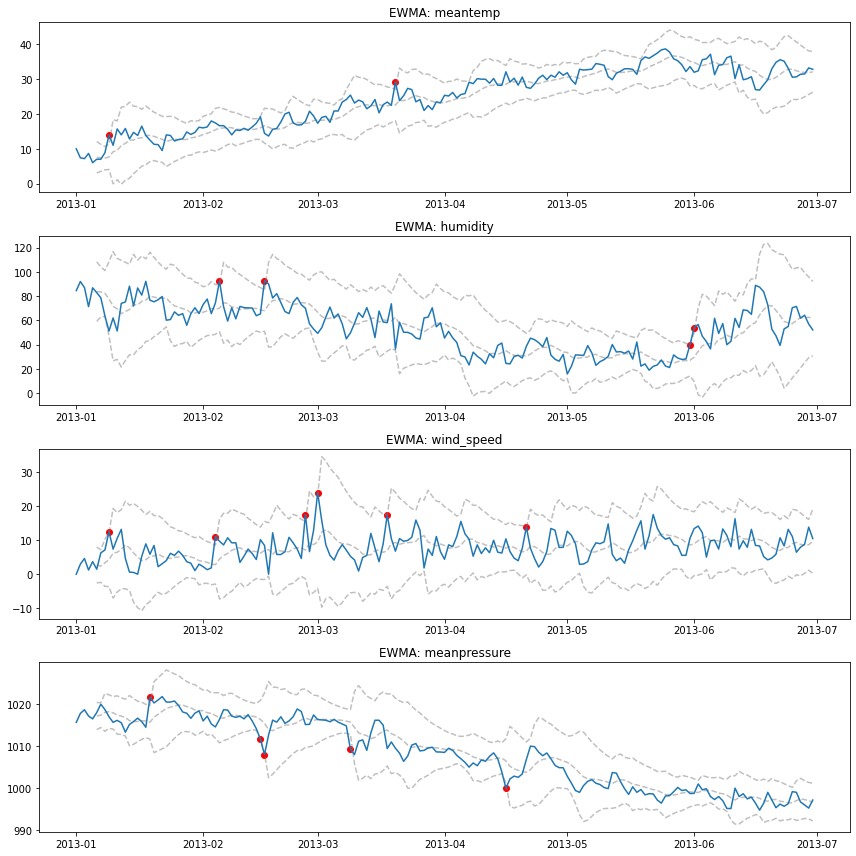

In [5]:
plot_ewma(df, "2013-01-01", "2013-06-30")

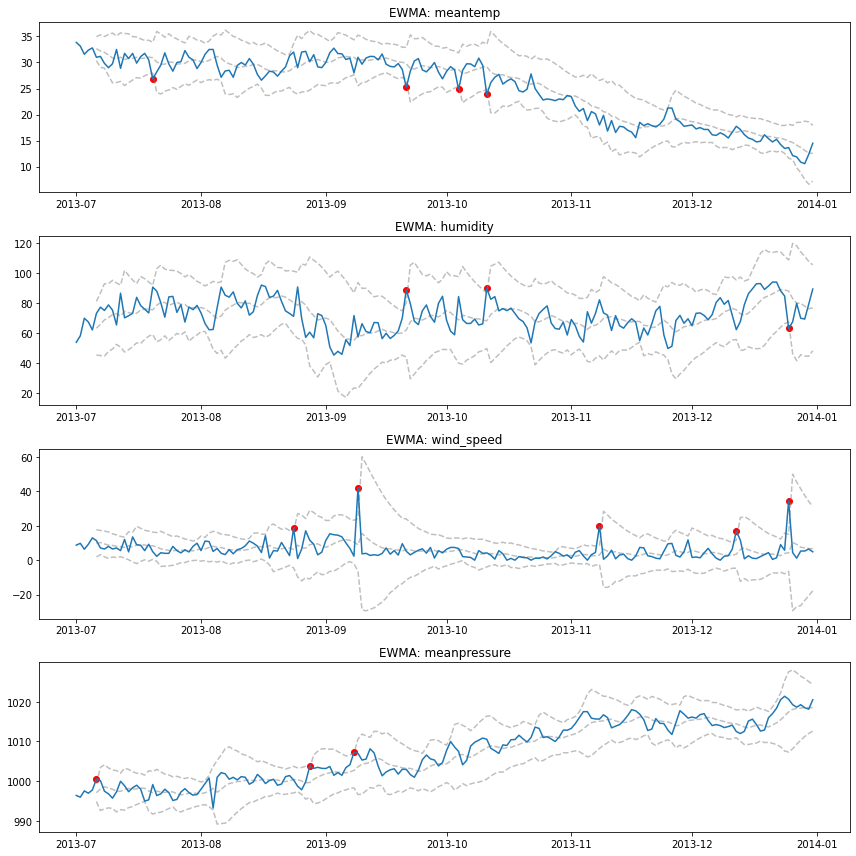

In [6]:
plot_ewma(df, "2013-07-01", "2013-12-31")

### 1.2 Single series, multiple parameterization 

In [7]:
def plot_ewma_multi_param(x, start, end, n_alphas=5, k=3.0):
    fig, ax = plt.subplots(
        nrows=n_alphas,
        ncols=1,
        figsize=(12, CHART_HEIGHT*n_alphas),
        tight_layout=True)
    for i in range(n_alphas):
        alpha = (i + 1) / n_alphas
        x = x.loc[start:end]
        result = exp.ewma(x, alpha, k)
        ad.plot.plot_anomalies(ax[i], result, f"EWMA: alpha={alpha}")

In [8]:
# Notice - no bands
exp.ewma(df["meantemp"]["2013-01-01":"2013-06-30"], 1.0, 3.0)

,x,mean,stdev,upper,lower,anomaly
date,,,,,,
2013-01-01,10.000000,NaN,NaN,NaN,NaN,False
2013-01-02,7.400000,NaN,NaN,NaN,NaN,False
2013-01-03,7.166667,NaN,NaN,NaN,NaN,False
2013-01-04,8.666667,NaN,NaN,NaN,NaN,False
2013-01-05,6.000000,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...
2013-06-26,30.666667,30.571429,NaN,NaN,NaN,False
2013-06-27,31.428571,30.666667,NaN,NaN,NaN,False
2013-06-28,31.500000,31.428571,NaN,NaN,NaN,False


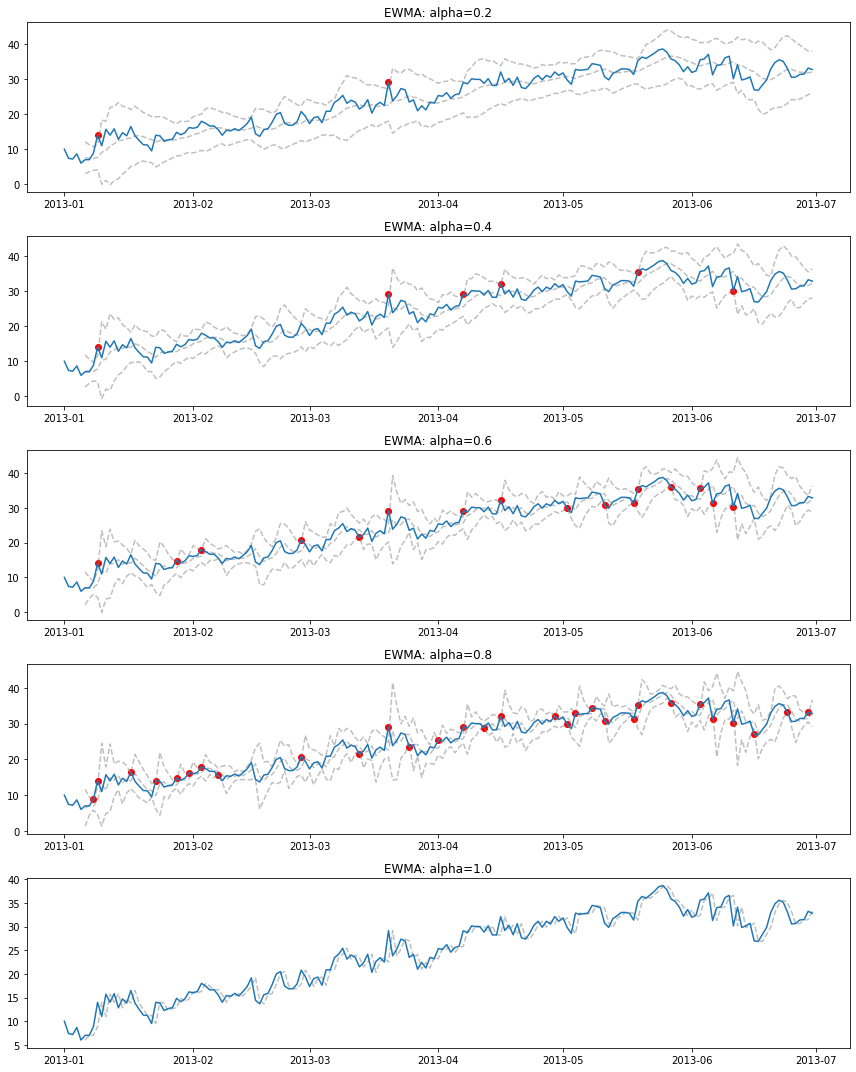

In [9]:
plot_ewma_multi_param(df["meantemp"], "2013-01-01", "2013-06-30", n_alphas=5, k=3.0)

## 2 PEWMA 

In [10]:
def plot_pewma(df, start, end, alpha=0.2, beta=0.8, k=3.0, T=10):
    nseries = df.shape[1]
    fig, ax = plt.subplots(nrows=nseries, ncols=1, figsize=(12, 3*nseries), tight_layout=True)
    for i, colname in enumerate(df.columns):
        x = df.loc[start:end, colname]
        result = exp.pewma(x, alpha, beta, k, T)
        ad.plot.plot_anomalies(ax[i], result, f"PEWMA: {colname}")

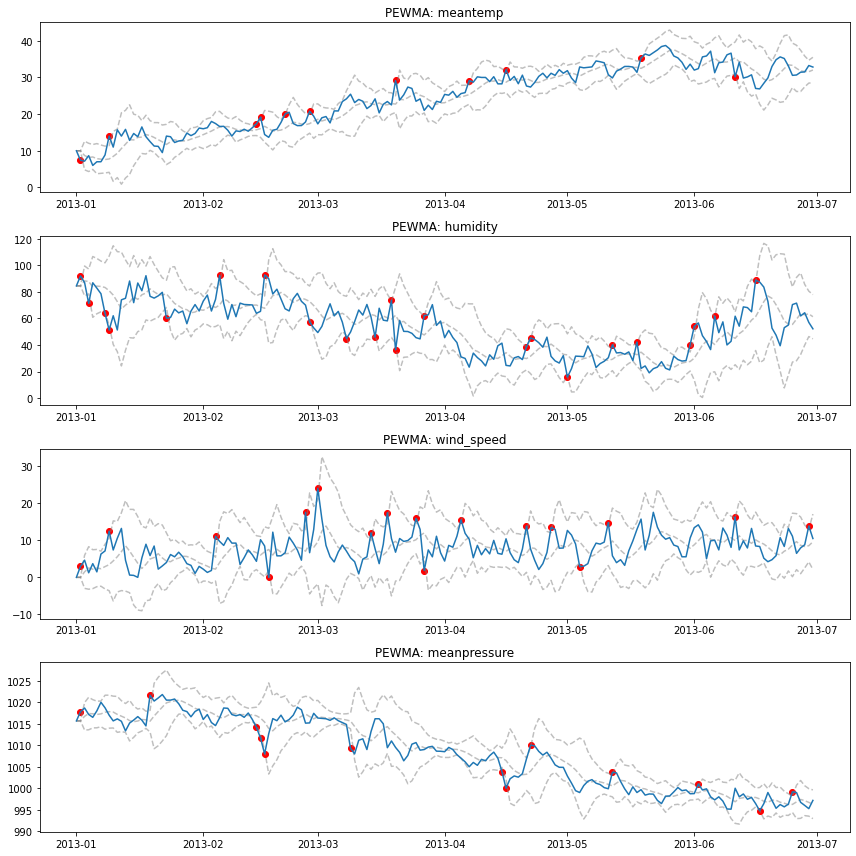

In [11]:
plot_pewma(df, "2013-01-01", "2013-06-30")

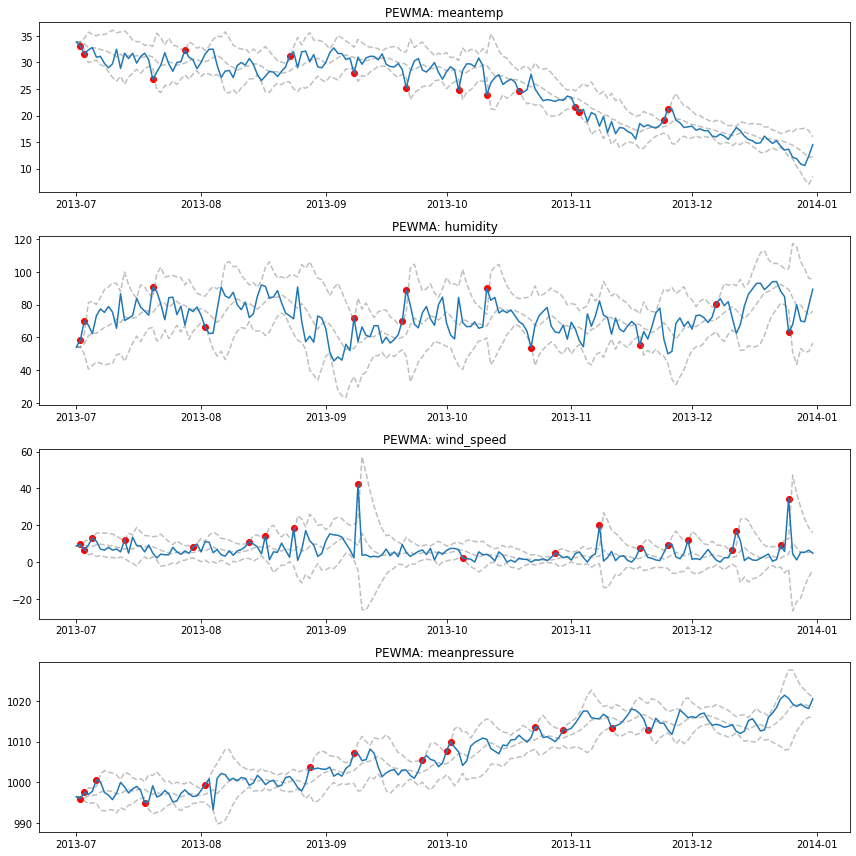

In [12]:
plot_pewma(df, "2013-07-01", "2013-12-31")

## 3 PEWMA vs EWMA

In [13]:
# FIXME Not correctly incorporating the training period.
# Notice that the stdev starts tight even with training.
def plot_pewma_vs_ewma(df, start, end, alpha=0.2, beta=0.8, k=3.0, T=10):
    nseries = df.shape[1]
    fig, ax = plt.subplots(nrows=nseries, ncols=1, figsize=(12, 3*nseries), tight_layout=True)
    for i, colname in enumerate(df.columns):
        x = df.loc[start:end, colname]
        ewma_result = exp.ewma(x, alpha, k)
        pewma_result = exp.pewma(x, alpha, beta, k, T)
        ax[i].set_title(f"EWMA vs PEWMA: {colname}")
        ax[i].plot(x, color="k", linestyle="-")
        ad.plot.plot_anomalies(ax[i], ewma_result, show_x=False, band_color="blue")
        ad.plot.plot_anomalies(ax[i], pewma_result, show_x=False, band_color="green")
        ax[i].legend(handles=[
            mpatches.Patch(color="k", label="Observed"),
            mpatches.Patch(color="blue", alpha=0.5, label="EWMA"),
            mpatches.Patch(color="green", alpha=0.5, label="PEWMA"),
            mpatches.Patch(color="r", label="Anomaly"),
        ])

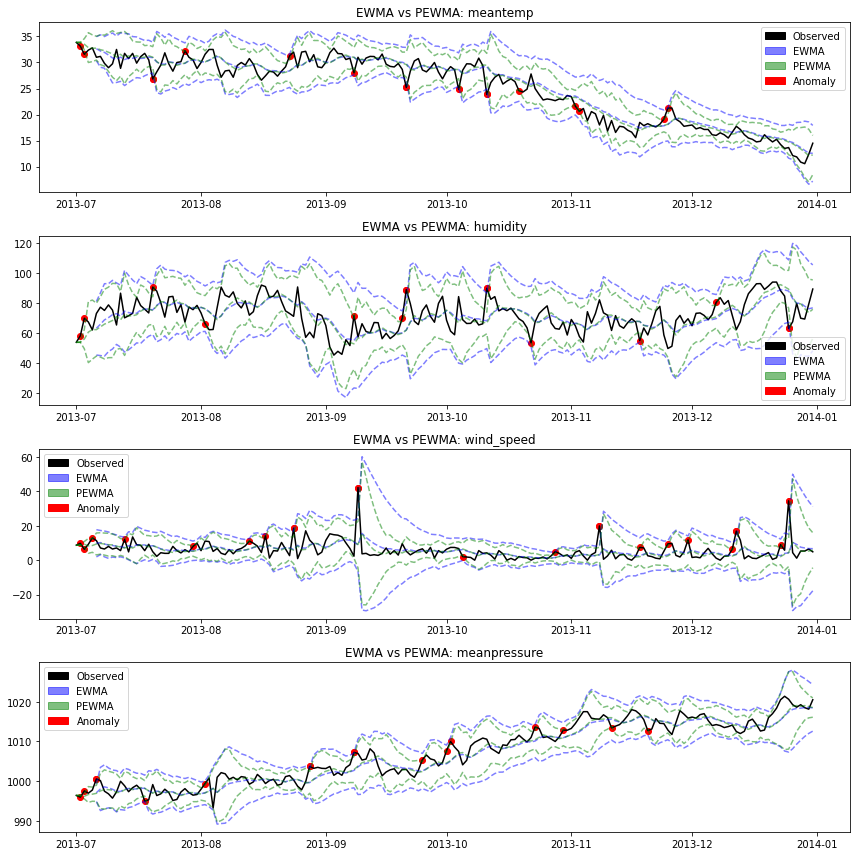

In [14]:
plot_pewma_vs_ewma(df, "2013-07-01", "2013-12-31")